# 10장. 시퀀스를 예측하는 머신러닝 모델 만들기

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch10/10-sequence-prediction.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch10/10-sequence-prediction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

## 윈도우 데이터셋 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [3]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[2 3 4 5]
 [5 6 7 8]]
y =  [[6]
 [9]]
x =  [[0 1 2 3]
 [1 2 3 4]]
y =  [[4]
 [5]]
x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [[8]
 [7]]


### 윈도우를 적용한 시계열 데이터셋 만들기

In [5]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1])
    )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, 
                           shuffle_buffer_size)

In [8]:
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
    print(feature)
    print(label)

tf.Tensor(
[[51.669804 52.137573 45.449688 44.976448 46.234913 35.856594 39.547764
  53.717186 54.86844  45.16099  49.053406 47.493305 61.099957 51.07409
  44.60956  40.246727 36.76993  45.599754 40.583595 37.03971 ]], shape=(1, 20), dtype=float32)
tf.Tensor([40.706562], shape=(1,), dtype=float32)


## DNN을 만들고 시퀀스 데이터로 훈련하기

In [9]:
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [10]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse",optimizer=sgd)

In [11]:
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 1272.7646
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 60.0839
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 56.1618
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 55.0454
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 52.6732
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 50.5440
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 49.5390
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 48.1359
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 51.8719
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 46.9190
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 45.6266
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 44.7713
Epoch 13/100
31/31 [===

## DNN의 결과 평가하기

In [12]:
print(series[1000:1020])

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]


In [13]:
print(series[1020])

106.258606


In [14]:
print(model.predict(series[1000:1020][np.newaxis]))

[[105.235435]]


In [15]:
start_point = 1000

print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(
      series[start_point:start_point+window_size][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
[[105.235435]]


## 전반적인 예측 살펴보기

In [16]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))

In [17]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [18]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

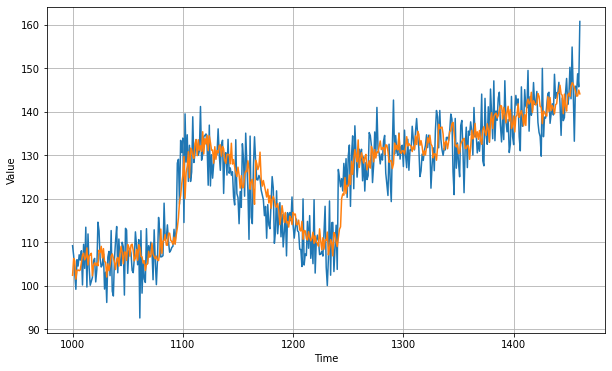

In [19]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.489912

## 학습률 튜닝

In [21]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, 
                    callbacks=[lr_schedule], verbose=0)

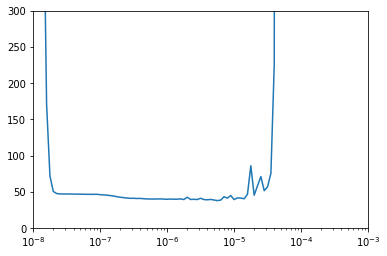

In [23]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

학습률 1e-6에서 다시 훈련

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse",optimizer=sgd)
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 479.9218
Epoch 2/100
31/31 [==============================] - 0s 977us/step - loss: 63.9323
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 48.6948
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 45.9316
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 43.2513
Epoch 6/100
31/31 [==============================] - 0s 925us/step - loss: 43.0130
Epoch 7/100
31/31 [==============================] - 0s 855us/step - loss: 42.5401
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 41.5784
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 41.0349
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 40.7020
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 40.5050
Epoch 12/100
31/31 [==============================] - 0s 901us/step - loss: 40.6537
Epoch 13/100
31/

In [25]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

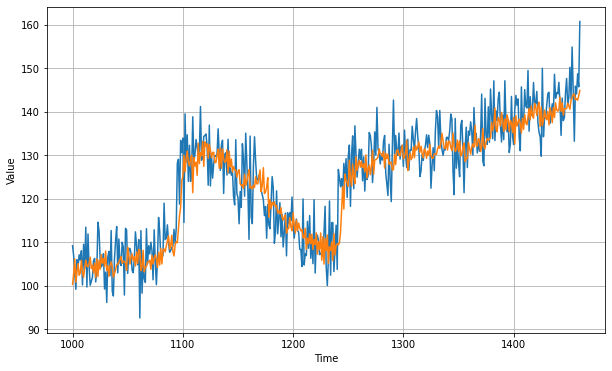

In [26]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.552256

## 케라스 튜너로 하이퍼파라미터 튜닝하기

In [28]:
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable


In [29]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=30, step=2), 
        activation='relu', input_shape=[window_size]))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    sgd = tf.keras.optimizers.SGD(
        learning_rate=1e-6,
        momentum=hp.Choice('momentum', values=[.9, .7, .5, .3]))
    model.compile(loss="mse", optimizer=sgd)
    return model

In [30]:
from keras_tuner.tuners import RandomSearch

In [31]:
tuner = RandomSearch(build_model,
                     objective='loss', max_trials=150, 
                     executions_per_trial=3, directory='my_dir', 
                     project_name='hello', overwrite=True)

In [32]:
tuner.search(dataset, epochs=100, verbose=0)

INFO:tensorflow:Oracle triggered exit


In [33]:
tuner.results_summary()

Results summary
Results in my_dir/hello
Showing 10 best trials
Trial summary
Hyperparameters:
units: 22
momentum: 0.9
Score: 33.8476931254069
Trial summary
Hyperparameters:
units: 24
momentum: 0.9
Score: 33.98278045654297
Trial summary
Hyperparameters:
units: 26
momentum: 0.9
Score: 34.0819206237793
Trial summary
Hyperparameters:
units: 16
momentum: 0.9
Score: 35.266363779703774
Trial summary
Hyperparameters:
units: 10
momentum: 0.9
Score: 35.660011291503906
Trial summary
Hyperparameters:
units: 14
momentum: 0.7
Score: 36.16016387939453
Trial summary
Hyperparameters:
units: 18
momentum: 0.7
Score: 36.265909830729164
Trial summary
Hyperparameters:
units: 22
momentum: 0.7
Score: 36.40578842163086
Trial summary
Hyperparameters:
units: 26
momentum: 0.7
Score: 36.425713857014976
Trial summary
Hyperparameters:
units: 30
momentum: 0.7
Score: 37.29307174682617


In [34]:
best_models = tuner.get_best_models(num_models=4)

In [35]:
model = best_models[0]

forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

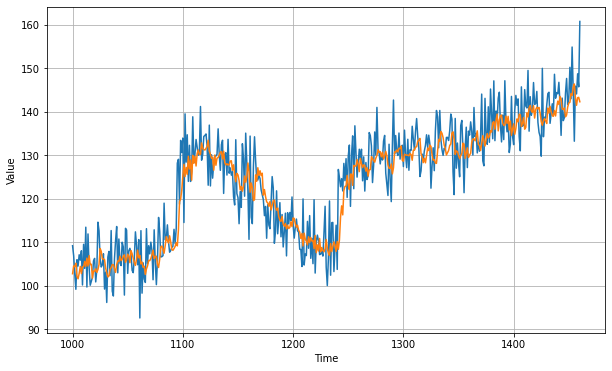

In [36]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.5624456